In [98]:
# Import relevant packages
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary

import os
import time
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

In [99]:
# Flags
DISABLE_CUDA = False
DEBUG = False

In [100]:
# Select accelerator device
def get_default_device():
    """Returns device, is_cuda (bool)."""
    if not DISABLE_CUDA and torch.cuda.is_available():
        print("Running on CUDA!")
        return torch.device('cuda'), True
    else:
        print("Running on CPU!")
        return torch.device('cpu'), False
device, using_cuda = get_default_device()

Running on CPU!


In [101]:
notebook_path = os.path.abspath("confusion_matrix.ipynb")
model_path = os.path.dirname(notebook_path) + '/models/CNN v1.4.2 resize, dropout in convs ~ dim=128, lr=0.0001, epochs=12, cuda=False.csv-model.pth'

model_dict = torch.load(model_path, map_location=device)

In [102]:
def declare_model(input_dim):
    class ConvNet(nn.Module):  # Convolutional Neural Network
        def __init__(self):
            super(ConvNet, self).__init__()
            self.layer1 = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.MaxPool2d(kernel_size=2, stride=2))
            self.layer2 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.MaxPool2d(kernel_size=2, stride=2))
            self.layer3 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.MaxPool2d(kernel_size=2, stride=2))
            self.layer4 = nn.Sequential(
                nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.MaxPool2d(kernel_size=2, stride=2))
            self.drop_out = nn.Dropout(0.2)
            # TODO this doesn't like intput_dim that aren't powers of 2 (e.g. 650)
            self.fc1 = nn.Linear(int(input_dim/8) * int(input_dim/8) * 4, 64)
            self.drop_out = nn.Dropout(0.4)
            self.fc2 = nn.Linear(64, 1)
            self.sigmoid = nn.Sigmoid()
            
        def forward(self, x):
            if DEBUG:
                print (x.shape)
            out = self.layer1(x)
            if DEBUG:
                print (out.shape)
            out = self.layer2(out)
            if DEBUG:
                print (out.shape)
            out = self.layer3(out)
            if DEBUG:
                print (out.shape)
            out = self.layer4(out)
            if DEBUG:
                print (out.shape)
            out = out.reshape(out.size(0), -1)
            if DEBUG:
                print (out.shape)
            out = self.fc1(out)
            out = self.drop_out(out)
            if DEBUG:
                print(out.shape)
            out = self.fc2(out)
            if DEBUG:
                print(out.shape)
            out = self.sigmoid(out)
            return out

    model = ConvNet()
    model.to(device)
    return model
model = declare_model(128)

In [103]:
model.load_state_dict(model_dict)

<All keys matched successfully>

In [104]:
data_path =  os.path.dirname(notebook_path) + '/data/ldrd-and-raise-datasets/image-folder'
train_test_ratio = 0.8

def obtain_data(input_dim):
    # Transform the data
    transform = transforms.Compose([
        transforms.Resize((input_dim, input_dim)),  # resize to square
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Create training/testing dataloaders
    full_set = datasets.ImageFolder(root=data_path, transform=transform)
    train_size = int(train_test_ratio * len(full_set))
    val_size = int((len(full_set) - train_size) / 2)
    test_size = len(full_set) - train_size - val_size
    train_set, val_set, test_set = torch.utils.data.random_split(
        full_set, [train_size, val_size, test_size])

    train_loader = torch.utils.data.DataLoader(train_set, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, shuffle=False)

    return train_loader, val_loader
train_loader, val_loader = obtain_data(128)

[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0,

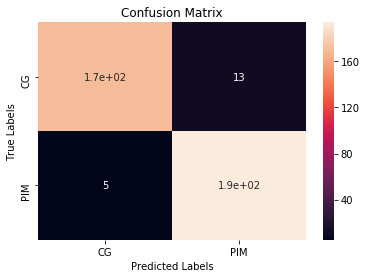

In [105]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np 

t = torch.Tensor([0.5]).to(device)

predlist = []
lbllist = []

with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        inputs = inputs.to(device)
        classes = classes.float().numpy()[0]
        outputs = model(inputs)
        preds = (outputs > t).float().numpy()[0][0]

        # Append batch prediction results
        predlist.append(preds)
        lbllist.append(classes)

# Confusion matrix
print (lbllist)
print (predlist)

labels = ['Actual', 'CGI']

conf_mat=confusion_matrix(np.array(lbllist), np.array(predlist))
df_cm = pd.DataFrame(conf_mat, range(2), range(2))

ax= plt.subplot()
sn.heatmap(conf_mat, annot=True, ax=ax)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['CG', 'PIM'])
ax.yaxis.set_ticklabels(['CG', 'PIM'])


plt.show()
print (conf_mat)

In [106]:
### trying saliency maps


from flashtorch.utils import apply_transforms, load_image
from flashtorch.saliency import Backprop
from flashtorch.activmax import GradientAscent

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
tensor([[0.9980]], grad_fn=<SigmoidBackward>)
tensor([[0.3285]], grad_fn=<SigmoidBackward>)


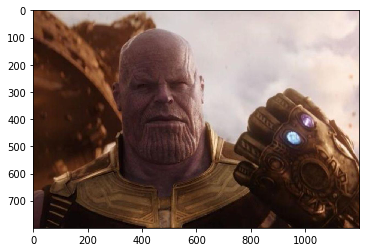

In [114]:
for example, label in val_loader:  
    sample_example = example[0]    
    sample_label = label[0]
    break

print (model(sample_example.unsqueeze(0)))
plt.imshow(sample_example.numpy().transpose((1, 2, 0)))

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # resize to square
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
thanos_data = datasets.ImageFolder(root=os.path.dirname(notebook_path) + '/thanos', transform=transform)
thanos_loader = torch.utils.data.DataLoader(thanos_data, shuffle=False)

for example, label in thanos_loader:
    thanos = example[0]

print (model(thanos.unsqueeze(0)))


regular_thanos = load_image(os.path.dirname(notebook_path) + '/thanos/thanos/thanos.jpeg')


In [119]:
backprop = Backprop(model)

image = load_image(os.path.dirname(notebook_path) + '/thanos/thanos/thanos.jpeg')

if not isinstance(image, Image.Image):
    image = F.to_pil_image(image)

    means = [0.5,
if not isinstance(image, Image.Image):
    image = F.to_pil_image(image)

means = [0.5, 0.5, 0.5]
stds = [0.5, 0.5, 0.5]

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

tensor = transform(image).unsqueeze(0)

tensor.requires_grad = True

transformed = tensor


plt.imshow(sample_image)
plt.show()
transformed = apply_transforms(sample_image, size=128)
print (transformed.size)

backprop.visualize(transformed, 0, guided=True)

AttributeError: 'NoneType' object has no attribute 'shape'